In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna

In [15]:
df_weather_hourly = pd.read_parquet(r'..\data\01_interim\weather_hourly_darksky_cleaned.parquet')

In [16]:
df_consumption_hourly = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly.parquet')

In [17]:
df_consumption_hourly = df_consumption_hourly.drop(columns=['Date','Acorn_grouped'])

### Test set: last 48h

In [18]:
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

In [19]:
df = df.drop(columns='apparentTemperature')

In [20]:
holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
holidays = pd.to_datetime(holidays['Bank holidays'])
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)

In [24]:
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.day_of_year
df['is_holiday'] = df['is_holiday'].astype(int)

In [25]:
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final 96 half‐hour rows (48h) of each ACORN as test
horizon_steps = 48 * 2  # 96 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (96 × #ACORN): {len(df_test)}\n")

Total rows: 80796
Training rows: 80508
Test rows (96 × #ACORN): 288



In [26]:
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","nb_clients","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0274, MAE = 0.0185

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0164, MAE = 0.0127

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0201, MAE = 0.0151

--- Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7319
    num__temperature                0.1371
    num__dayofyear                  0.0486
    num__nb_clients                 0.0148
    num__dayofweek                  0.0120
    num__humidity                   0.0092
    num__pressure                   0.0083
    num__windSpeed                  0.0078
    num__visibility                 0.0062
    num__windBearing                0.0062


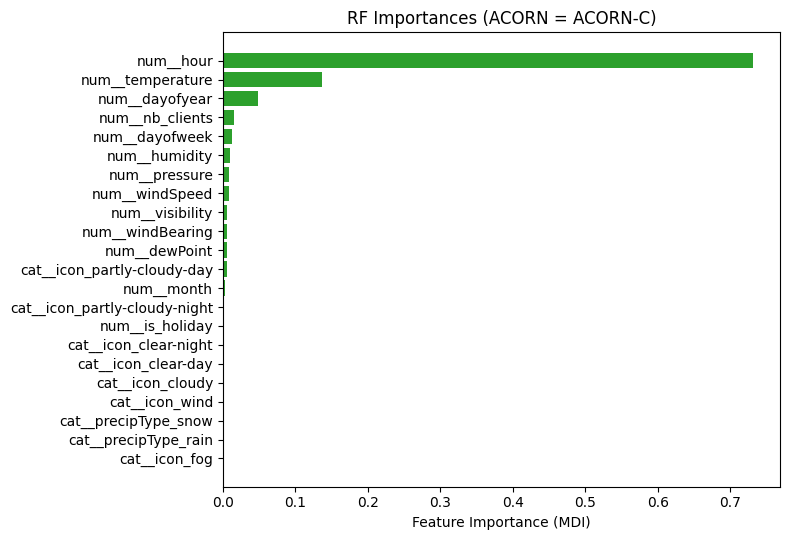

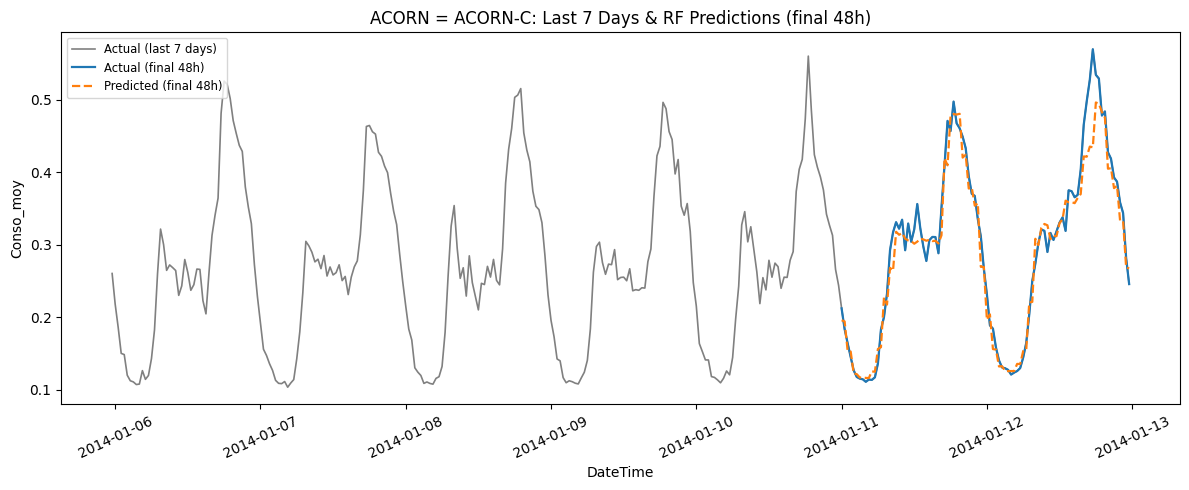


--- Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7043
    num__temperature                0.1880
    num__dayofyear                  0.0477
    num__dayofweek                  0.0192
    num__nb_clients                 0.0071
    num__windSpeed                  0.0048
    num__pressure                   0.0044
    num__dewPoint                   0.0042
    num__humidity                   0.0040
    num__visibility                 0.0039


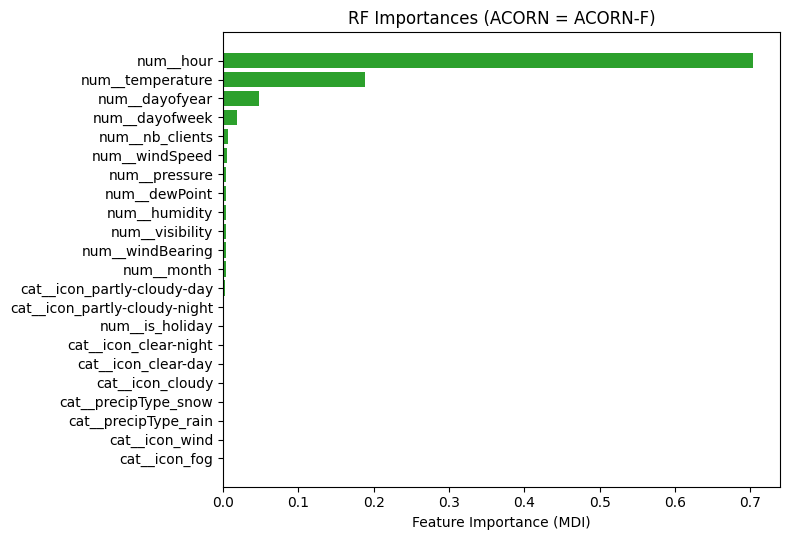

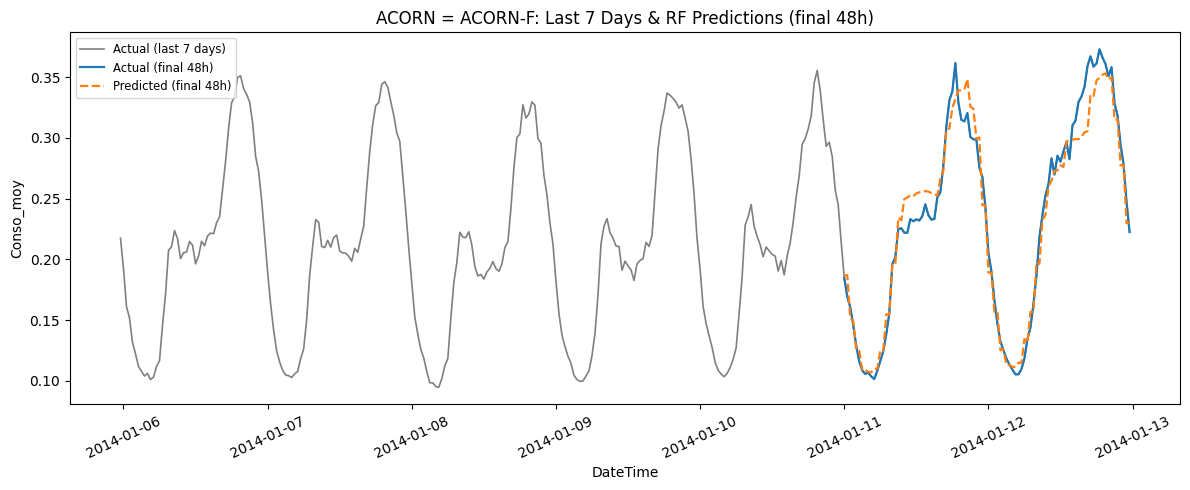


--- Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5991
    num__temperature                0.1308
    num__dayofyear                  0.0959
    num__nb_clients                 0.0538
    num__pressure                   0.0192
    num__windBearing                0.0187
    num__visibility                 0.0184
    num__windSpeed                  0.0182
    num__dewPoint                   0.0157
    num__humidity                   0.0105


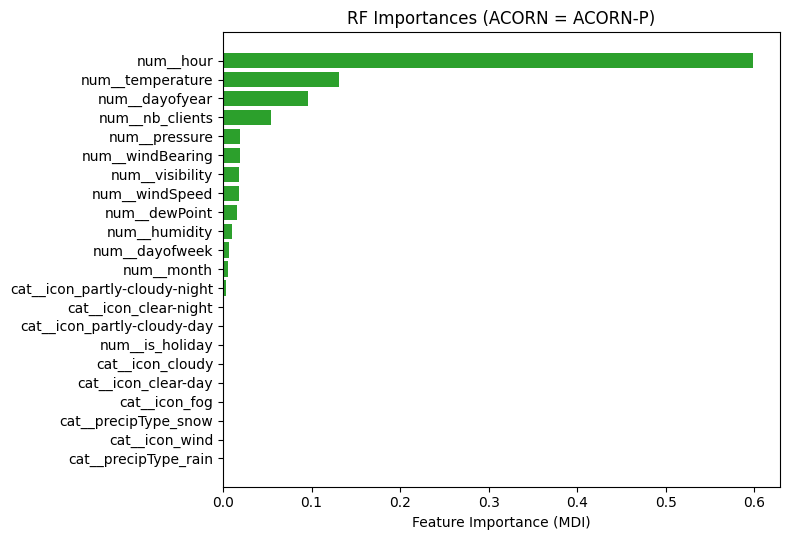

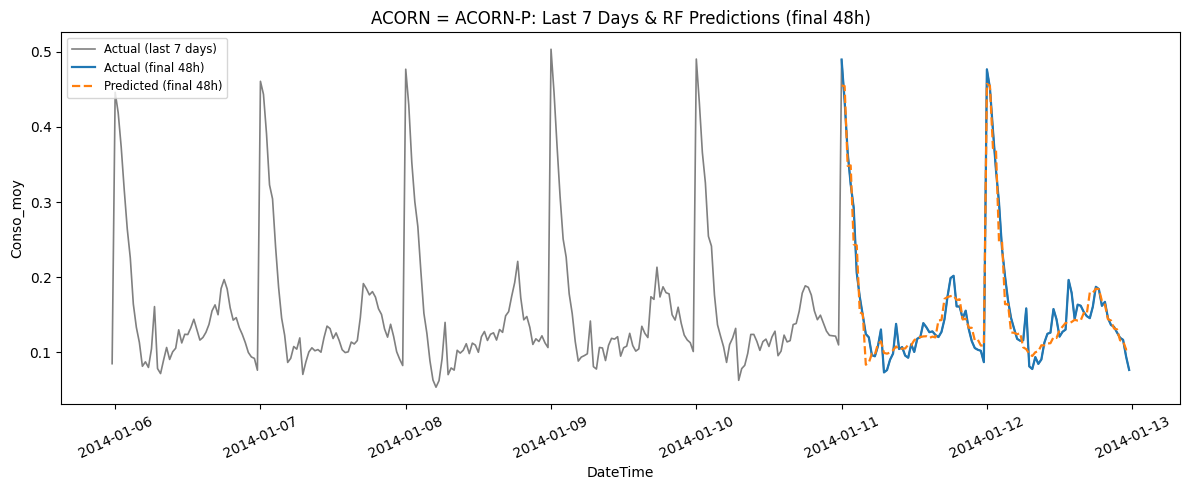

In [ ]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # 5.1) Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # 5.2) Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # 5.3) Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # 5.5) Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # 5.6) Predict on this ACORN’s test set (final 48h)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # 5.7) Compute RMSE / MAE on held‐out 48h
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}")
    
    # 5.8) Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# 6) FEATURE IMPORTANCE AND PLOTTING LAST 7 DAYS PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # 6.A) FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # 6.A.1) Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # 6.A.2) Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # 6.B) PLOT LAST 7 DAYS WITH FINAL 48h PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last 7 days (gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    # Actual final 48h (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final 48h)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final 48h (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final 48h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days & RF Predictions (final 48h)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

### Test set: last week

Total rows: 80796
Training rows: 79788
Test rows (336 × #ACORN): 1008


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0256, MAE = 0.0191

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0145, MAE = 0.0117

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0238, MAE = 0.0178

--- Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7280
    num__temperature                0.1354
    num__dayofyear                  0.0498
    num__nb_clients                 0.0153
    num__dayofweek                  0.0122
    num__humidity                   0.0090
    num__pressure                   0.0083
    num__windSpeed                  0.0078
    cat__icon_partly-cloudy-night   0.0063
    num__visibility                 0.0062


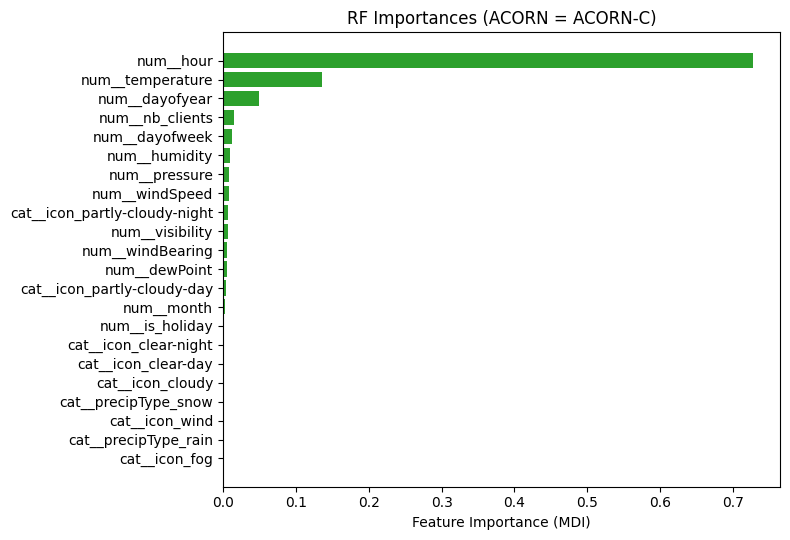

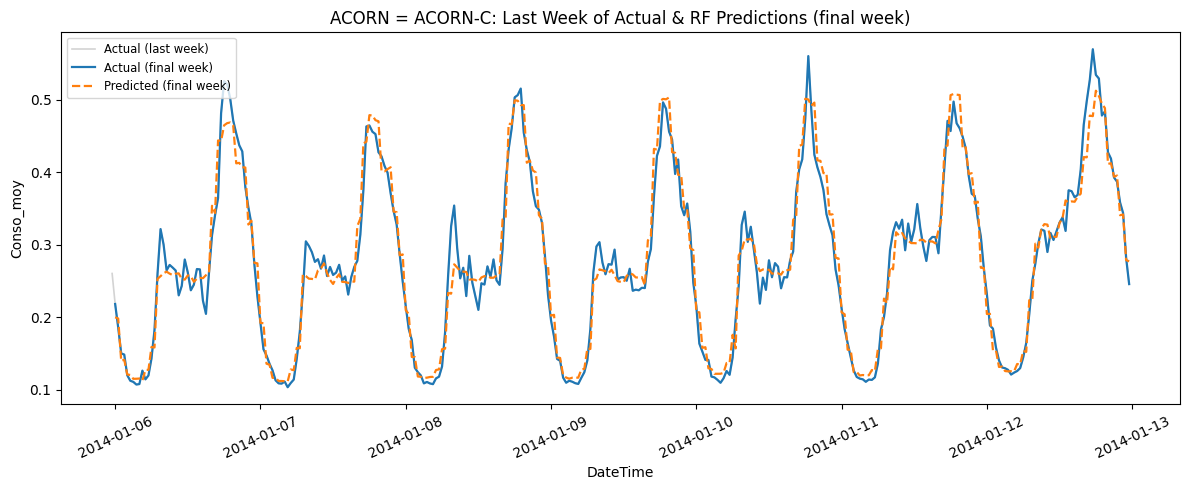


--- Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7022
    num__temperature                0.1886
    num__dayofyear                  0.0495
    num__dayofweek                  0.0191
    num__nb_clients                 0.0073
    num__windSpeed                  0.0048
    num__pressure                   0.0044
    num__dewPoint                   0.0043
    num__humidity                   0.0041
    num__windBearing                0.0039


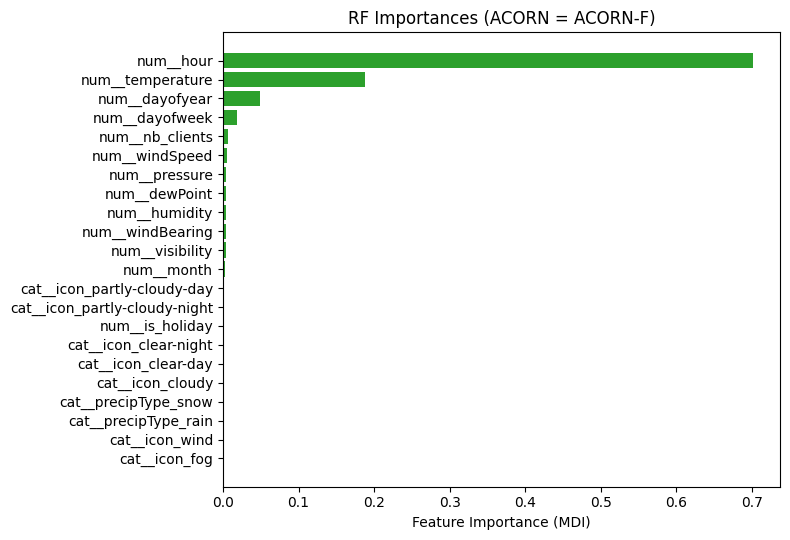

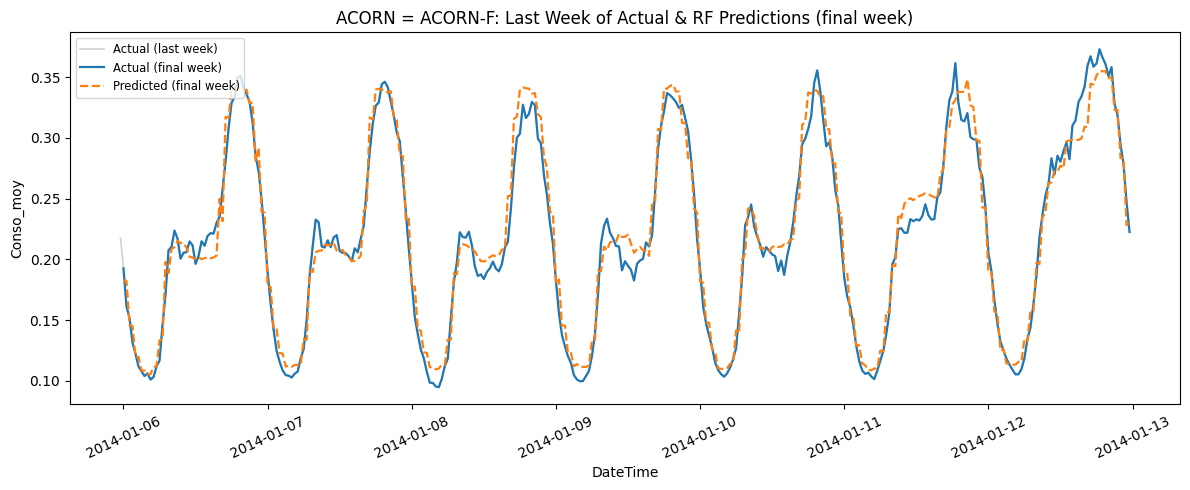


--- Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5973
    num__temperature                0.1316
    num__dayofyear                  0.0923
    num__nb_clients                 0.0589
    num__pressure                   0.0195
    num__windBearing                0.0192
    num__visibility                 0.0183
    num__windSpeed                  0.0171
    num__dewPoint                   0.0160
    num__humidity                   0.0107


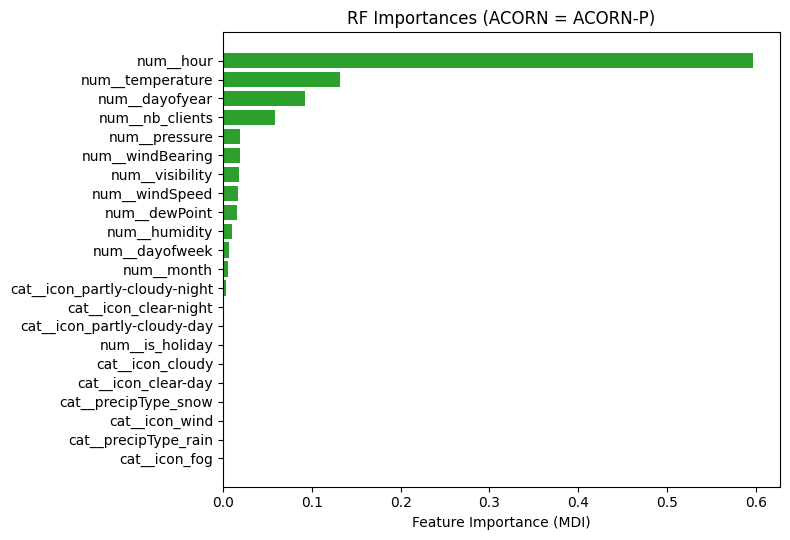

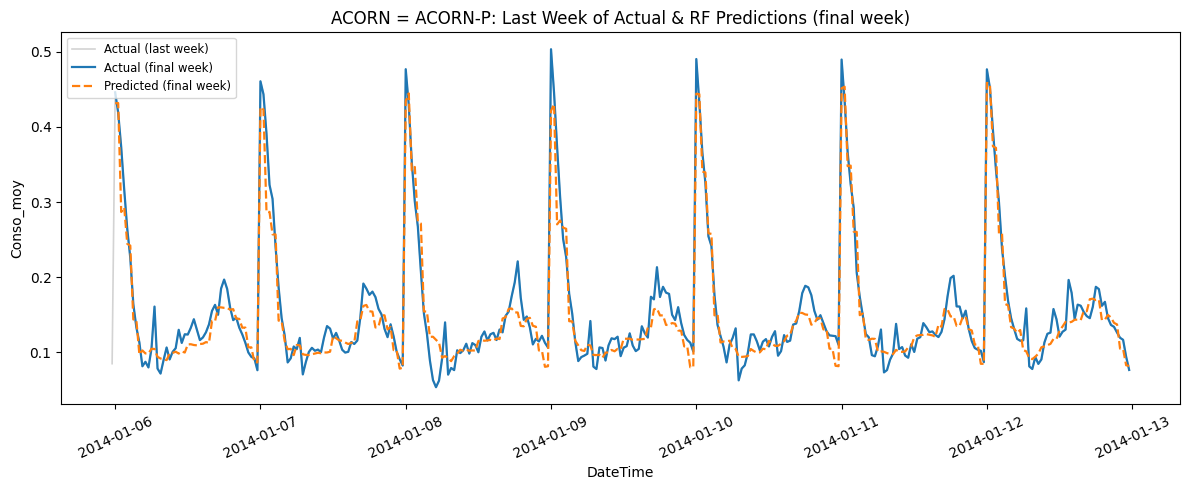

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

# Extract hour, day of week, month, and day of year
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.dayofyear
df = df.drop(columns='apparentTemperature')
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)


# ──────────────────────────────────────────────────────────────────────────────
# SORT BY ACORN & DATETIME, ASSIGN WITHIN‐GROUP INDEX, AND SPLIT FINAL WEEK AS TEST
# ──────────────────────────────────────────────────────────────────────────────
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# Compute each ACORN group’s size
group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final week (7 days = 7*48 half‐hour rows = 336) of each ACORN as test
horizon_steps = 7 * 48  # 336 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (336 × #ACORN): {len(df_test)}\n")

# ──────────────────────────────────────────────────────────────────────────────
# DEFINE FEATURE COLUMNS
# ──────────────────────────────────────────────────────────────────────────────
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","nb_clients","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]

# ──────────────────────────────────────────────────────────────────────────────
# LOOP OVER EACH ACORN TO TRAIN A RF WITH DEFAULT HYPERPARAMETERS
# ──────────────────────────────────────────────────────────────────────────────
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # Predict on this ACORN’s test set (final week)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}")
    
    # Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE AND PLOTTING LAST WEEK PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # PLOT LAST WEEK WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last week (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last week)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


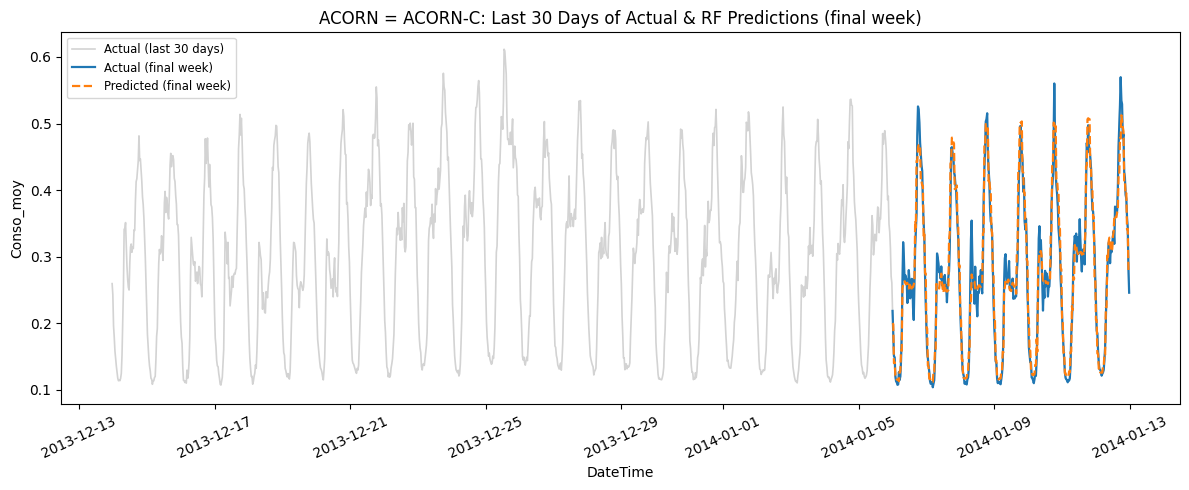

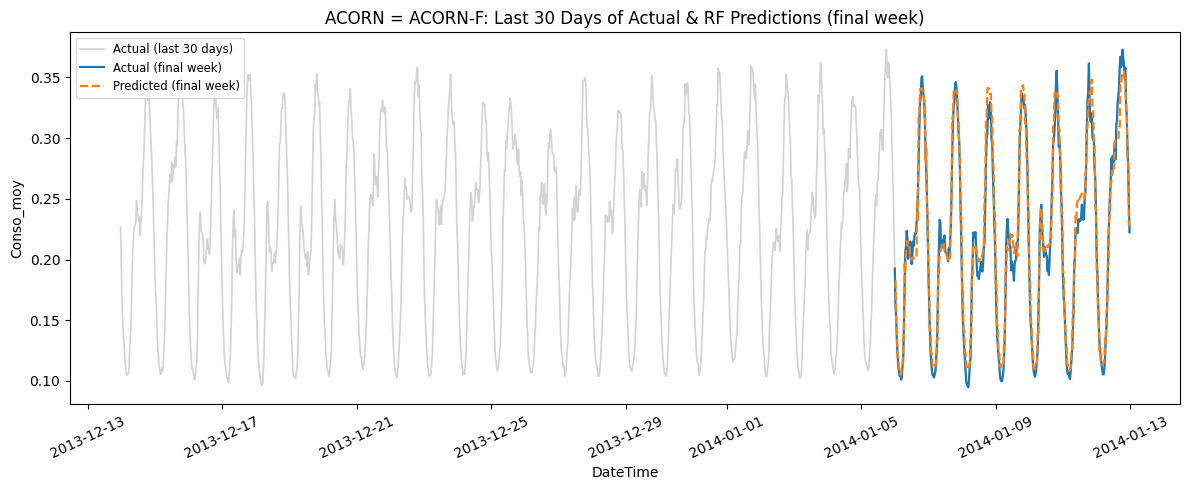

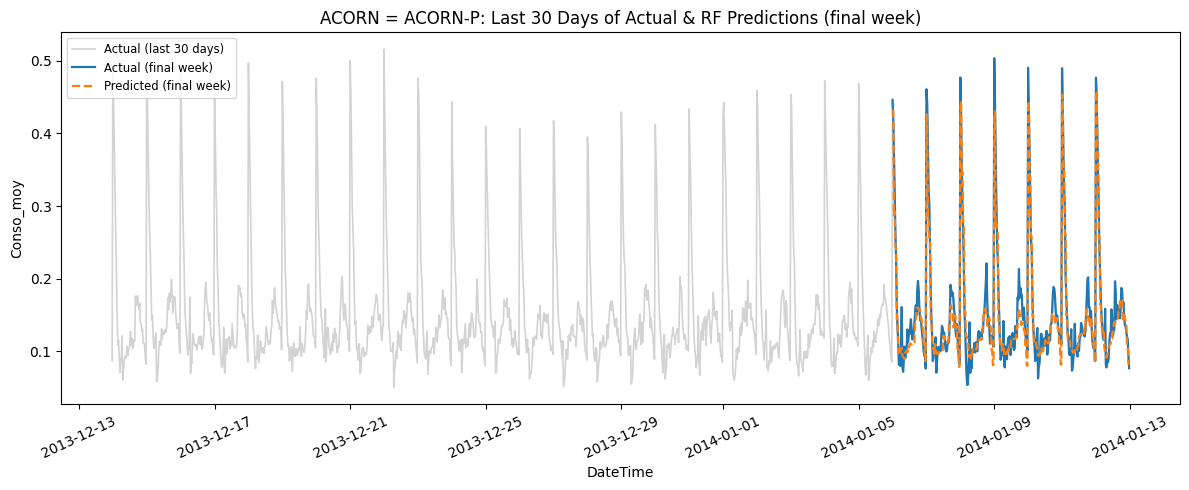

In [31]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot the last month of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # 1) Full history for this ACORN, sorted by DateTime
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # 2) Compute one month ago (30 days)
    one_month_ago = last_timestamp - pd.Timedelta(days=30)
    
    # 3) Filter to only the last 30 days of actual consumption
    last_month_df = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    # 4) Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # 5) Plot
    plt.figure(figsize=(12, 5))
    
    # 5A) Last 30 days actual (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last 30 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # 5B) Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 30 Days of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


### Hyperparameter tuning

In [33]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== TUNING & TRAINING RF FOR ACORN = {acorn_label} ===")
    
    # 5.1) Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # 5.2) Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # 5.3) Build ColumnTransformer (no “Acorn”)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) Define Optuna objective for this ACORN
    def objective(trial):
        n_estimators     = trial.suggest_int("n_estimators", 50, 300)
        max_depth        = trial.suggest_int("max_depth", 5, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features     = trial.suggest_categorical("max_features", ["sqrt","log2",None])
        
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("rf", rf),
        ])
        
        tscv = TimeSeriesSplit(n_splits=3)
        neg_rmse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        # cross_val_score returns negative RMSE; convert to positive
        rmse_scores = -neg_rmse
        return float(rmse_scores.mean())
    
    # 5.5) Run Optuna search for this ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
    
    # 5.6) Rebuild pipeline with best hyperparameters
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=42,
        n_jobs=-1
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", best_rf),
    ])
    
    # 5.7) Fit on full train subset for this ACORN
    best_pipe.fit(X_train_sub, y_train_sub)
    
    # 5.8) Predict on test subset (final week)
    y_pred_sub = best_pipe.predict(X_test_sub)
    
    # 5.9) Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    print(f"  → Held‐out week Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}")
    
    # 5.10) Store results
    results_rf[acorn_label] = {
        "best_params":  best_params,
        "cv_rmse":      study.best_value,
        "test_rmse":    rmse_sub,
        "test_mae":     mae_sub,
        "pipeline":     best_pipe,
        "X_test_sub":   X_test_sub,
        "y_test_sub":   y_test_sub.values,
        "y_pred_sub":   y_pred_sub,
        "df_test_sub":  sub_test,
    }


[I 2025-06-05 11:15:13,719] A new study created in memory with name: no-name-f82e9943-a173-433c-a4b2-23ed930e2eb3



=== TUNING & TRAINING RF FOR ACORN = ACORN-C ===
  Train size = 26596, Test size = 336


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.0630302:   2%|▏         | 1/50 [00:02<02:05,  2.55s/it]

[I 2025-06-05 11:15:16,272] Trial 0 finished with value: 0.06303018820855157 and parameters: {'n_estimators': 217, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.06303018820855157.


Best trial: 1. Best value: 0.0617376:   4%|▍         | 2/50 [00:05<02:00,  2.52s/it]

[I 2025-06-05 11:15:18,766] Trial 1 finished with value: 0.06173761446917687 and parameters: {'n_estimators': 232, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.06173761446917687.


Best trial: 1. Best value: 0.0617376:   6%|▌         | 3/50 [00:07<01:52,  2.40s/it]

[I 2025-06-05 11:15:21,027] Trial 2 finished with value: 0.06178957559421391 and parameters: {'n_estimators': 198, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.06173761446917687.


Best trial: 3. Best value: 0.0590442:   8%|▊         | 4/50 [00:10<02:12,  2.88s/it]

[I 2025-06-05 11:15:24,649] Trial 3 finished with value: 0.0590441667250261 and parameters: {'n_estimators': 198, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.0590441667250261.


Best trial: 3. Best value: 0.0590442:  10%|█         | 5/50 [00:11<01:40,  2.23s/it]

[I 2025-06-05 11:15:25,710] Trial 4 finished with value: 0.061851891451917496 and parameters: {'n_estimators': 159, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.0590441667250261.


Best trial: 3. Best value: 0.0590442:  12%|█▏        | 6/50 [00:12<01:16,  1.73s/it]

[I 2025-06-05 11:15:26,488] Trial 5 finished with value: 0.06273085144967507 and parameters: {'n_estimators': 115, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.0590441667250261.


Best trial: 3. Best value: 0.0590442:  14%|█▍        | 7/50 [00:13<01:07,  1.57s/it]

[I 2025-06-05 11:15:27,713] Trial 6 finished with value: 0.06464657728054815 and parameters: {'n_estimators': 247, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 0.0590441667250261.


Best trial: 7. Best value: 0.0582655:  16%|█▌        | 8/50 [00:17<01:30,  2.16s/it]

[I 2025-06-05 11:15:31,158] Trial 7 finished with value: 0.05826553001378454 and parameters: {'n_estimators': 174, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 7 with value: 0.05826553001378454.


Best trial: 7. Best value: 0.0582655:  18%|█▊        | 9/50 [00:17<01:07,  1.65s/it]

[I 2025-06-05 11:15:31,666] Trial 8 finished with value: 0.062102730329984035 and parameters: {'n_estimators': 51, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 7 with value: 0.05826553001378454.


Best trial: 9. Best value: 0.0567224:  20%|██        | 10/50 [00:24<02:05,  3.13s/it]

[I 2025-06-05 11:15:38,115] Trial 9 finished with value: 0.056722449496290246 and parameters: {'n_estimators': 253, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 9 with value: 0.056722449496290246.


Best trial: 9. Best value: 0.0567224:  22%|██▏       | 11/50 [00:31<02:52,  4.41s/it]

[I 2025-06-05 11:15:45,443] Trial 10 finished with value: 0.05676372260261312 and parameters: {'n_estimators': 293, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 9 with value: 0.056722449496290246.


Best trial: 11. Best value: 0.056627:  24%|██▍       | 12/50 [00:38<03:16,  5.16s/it]

[I 2025-06-05 11:15:52,321] Trial 11 finished with value: 0.05662697954939997 and parameters: {'n_estimators': 283, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 11 with value: 0.05662697954939997.


Best trial: 12. Best value: 0.0566259:  26%|██▌       | 13/50 [00:46<03:38,  5.91s/it]

[I 2025-06-05 11:15:59,937] Trial 12 finished with value: 0.05662587136931981 and parameters: {'n_estimators': 299, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 12 with value: 0.05662587136931981.


Best trial: 13. Best value: 0.0555823:  28%|██▊       | 14/50 [00:55<04:03,  6.78s/it]

[I 2025-06-05 11:16:08,730] Trial 13 finished with value: 0.0555823421646874 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.0555823421646874.


Best trial: 13. Best value: 0.0555823:  30%|███       | 15/50 [01:04<04:20,  7.46s/it]

[I 2025-06-05 11:16:17,754] Trial 14 finished with value: 0.055606676656709576 and parameters: {'n_estimators': 278, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.0555823421646874.


Best trial: 13. Best value: 0.0555823:  32%|███▏      | 16/50 [01:13<04:33,  8.04s/it]

[I 2025-06-05 11:16:27,154] Trial 15 finished with value: 0.055596809492994864 and parameters: {'n_estimators': 265, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.0555823421646874.


Best trial: 16. Best value: 0.0553803:  34%|███▍      | 17/50 [01:18<03:52,  7.04s/it]

[I 2025-06-05 11:16:31,862] Trial 16 finished with value: 0.055380267849108766 and parameters: {'n_estimators': 120, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.055380267849108766.


Best trial: 16. Best value: 0.0553803:  36%|███▌      | 18/50 [01:23<03:27,  6.49s/it]

[I 2025-06-05 11:16:37,084] Trial 17 finished with value: 0.055432902484253345 and parameters: {'n_estimators': 132, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.055380267849108766.


Best trial: 18. Best value: 0.0553747:  38%|███▊      | 19/50 [01:28<03:08,  6.06s/it]

[I 2025-06-05 11:16:42,152] Trial 18 finished with value: 0.05537468504644779 and parameters: {'n_estimators': 124, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 18 with value: 0.05537468504644779.


Best trial: 18. Best value: 0.0553747:  40%|████      | 20/50 [01:29<02:18,  4.60s/it]

[I 2025-06-05 11:16:43,350] Trial 19 finished with value: 0.059388992246497636 and parameters: {'n_estimators': 107, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.05537468504644779.


Best trial: 18. Best value: 0.0553747:  42%|████▏     | 21/50 [01:32<01:56,  4.03s/it]

[I 2025-06-05 11:16:46,049] Trial 20 finished with value: 0.056991145818937904 and parameters: {'n_estimators': 70, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.05537468504644779.


Best trial: 18. Best value: 0.0553747:  44%|████▍     | 22/50 [01:37<02:04,  4.46s/it]

[I 2025-06-05 11:16:51,498] Trial 21 finished with value: 0.05538474320115807 and parameters: {'n_estimators': 133, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 18 with value: 0.05537468504644779.


Best trial: 22. Best value: 0.055302:  46%|████▌     | 23/50 [01:43<02:08,  4.75s/it] 

[I 2025-06-05 11:16:56,916] Trial 22 finished with value: 0.055301979068847505 and parameters: {'n_estimators': 137, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 22 with value: 0.055301979068847505.


Best trial: 22. Best value: 0.055302:  48%|████▊     | 24/50 [01:47<01:57,  4.51s/it]

[I 2025-06-05 11:17:00,863] Trial 23 finished with value: 0.05551189347588892 and parameters: {'n_estimators': 95, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 22 with value: 0.055301979068847505.


Best trial: 22. Best value: 0.055302:  50%|█████     | 25/50 [01:53<02:03,  4.92s/it]

[I 2025-06-05 11:17:06,757] Trial 24 finished with value: 0.05531005665823374 and parameters: {'n_estimators': 141, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 22 with value: 0.055301979068847505.


Best trial: 25. Best value: 0.0549535:  52%|█████▏    | 26/50 [01:59<02:05,  5.24s/it]

[I 2025-06-05 11:17:12,748] Trial 25 finished with value: 0.05495349754771211 and parameters: {'n_estimators': 150, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 25 with value: 0.05495349754771211.


Best trial: 25. Best value: 0.0549535:  54%|█████▍    | 27/50 [02:05<02:06,  5.51s/it]

[I 2025-06-05 11:17:18,886] Trial 26 finished with value: 0.05506789533254632 and parameters: {'n_estimators': 151, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 25 with value: 0.05495349754771211.


Best trial: 27. Best value: 0.054775:  56%|█████▌    | 28/50 [02:11<02:05,  5.70s/it] 

[I 2025-06-05 11:17:25,039] Trial 27 finished with value: 0.05477496436155396 and parameters: {'n_estimators': 159, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 27 with value: 0.05477496436155396.


Best trial: 27. Best value: 0.054775:  58%|█████▊    | 29/50 [02:12<01:32,  4.42s/it]

[I 2025-06-05 11:17:26,452] Trial 28 finished with value: 0.059037469092957394 and parameters: {'n_estimators': 162, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.05477496436155396.


Best trial: 27. Best value: 0.054775:  60%|██████    | 30/50 [02:13<01:06,  3.34s/it]

[I 2025-06-05 11:17:27,271] Trial 29 finished with value: 0.07431782496108856 and parameters: {'n_estimators': 201, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 27 with value: 0.05477496436155396.


Best trial: 27. Best value: 0.054775:  62%|██████▏   | 31/50 [02:15<00:53,  2.80s/it]

[I 2025-06-05 11:17:28,830] Trial 30 finished with value: 0.05975054123744827 and parameters: {'n_estimators': 157, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.05477496436155396.


Best trial: 31. Best value: 0.0545752:  64%|██████▍   | 32/50 [02:21<01:12,  4.01s/it]

[I 2025-06-05 11:17:35,665] Trial 31 finished with value: 0.054575245295734744 and parameters: {'n_estimators': 181, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  66%|██████▌   | 33/50 [02:29<01:23,  4.93s/it]

[I 2025-06-05 11:17:42,747] Trial 32 finished with value: 0.05461024240867848 and parameters: {'n_estimators': 186, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  68%|██████▊   | 34/50 [02:37<01:33,  5.85s/it]

[I 2025-06-05 11:17:50,725] Trial 33 finished with value: 0.054861188679964375 and parameters: {'n_estimators': 215, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  70%|███████   | 35/50 [02:45<01:37,  6.52s/it]

[I 2025-06-05 11:17:58,820] Trial 34 finished with value: 0.05477335943495316 and parameters: {'n_estimators': 229, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  72%|███████▏  | 36/50 [02:51<01:30,  6.47s/it]

[I 2025-06-05 11:18:05,182] Trial 35 finished with value: 0.05514735297838728 and parameters: {'n_estimators': 184, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  74%|███████▍  | 37/50 [02:53<01:05,  5.02s/it]

[I 2025-06-05 11:18:06,821] Trial 36 finished with value: 0.06165277004064445 and parameters: {'n_estimators': 221, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  76%|███████▌  | 38/50 [02:54<00:48,  4.02s/it]

[I 2025-06-05 11:18:08,491] Trial 37 finished with value: 0.0609302029983795 and parameters: {'n_estimators': 187, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  78%|███████▊  | 39/50 [03:01<00:54,  4.98s/it]

[I 2025-06-05 11:18:15,701] Trial 38 finished with value: 0.05537795271697635 and parameters: {'n_estimators': 238, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  80%|████████  | 40/50 [03:03<00:40,  4.03s/it]

[I 2025-06-05 11:18:17,535] Trial 39 finished with value: 0.05994060875266788 and parameters: {'n_estimators': 209, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  82%|████████▏ | 41/50 [03:08<00:37,  4.18s/it]

[I 2025-06-05 11:18:22,054] Trial 40 finished with value: 0.05674018346631274 and parameters: {'n_estimators': 170, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  84%|████████▍ | 42/50 [03:16<00:41,  5.24s/it]

[I 2025-06-05 11:18:29,787] Trial 41 finished with value: 0.05480421279062073 and parameters: {'n_estimators': 225, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  86%|████████▌ | 43/50 [03:23<00:41,  5.93s/it]

[I 2025-06-05 11:18:37,330] Trial 42 finished with value: 0.05518253103601956 and parameters: {'n_estimators': 229, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  88%|████████▊ | 44/50 [03:30<00:37,  6.22s/it]

[I 2025-06-05 11:18:44,221] Trial 43 finished with value: 0.05523885999762787 and parameters: {'n_estimators': 183, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  90%|█████████ | 45/50 [03:37<00:32,  6.42s/it]

[I 2025-06-05 11:18:51,088] Trial 44 finished with value: 0.05561971239725815 and parameters: {'n_estimators': 249, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  92%|█████████▏| 46/50 [03:41<00:22,  5.59s/it]

[I 2025-06-05 11:18:54,760] Trial 45 finished with value: 0.06132671823856856 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  94%|█████████▍| 47/50 [03:43<00:13,  4.55s/it]

[I 2025-06-05 11:18:56,883] Trial 46 finished with value: 0.06027634218808483 and parameters: {'n_estimators': 228, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  96%|█████████▌| 48/50 [03:49<00:10,  5.03s/it]

[I 2025-06-05 11:19:03,039] Trial 47 finished with value: 0.055076987712113196 and parameters: {'n_estimators': 193, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752:  98%|█████████▊| 49/50 [03:54<00:05,  5.19s/it]

[I 2025-06-05 11:19:08,612] Trial 48 finished with value: 0.05603834817868134 and parameters: {'n_estimators': 170, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.


Best trial: 31. Best value: 0.0545752: 100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


[I 2025-06-05 11:19:16,122] Trial 49 finished with value: 0.05642536404553461 and parameters: {'n_estimators': 240, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 31 with value: 0.054575245295734744.
  → Best params: {'n_estimators': 181, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}
  → Best CV‐RMSE = 0.0546


[I 2025-06-05 11:19:20,760] A new study created in memory with name: no-name-86ec083d-ded4-4268-bd3d-ac1d1625442d


  → Held‐out week Test RMSE = 0.0258, MAE = 0.0191

=== TUNING & TRAINING RF FOR ACORN = ACORN-F ===
  Train size = 26596, Test size = 336


Best trial: 0. Best value: 0.039252:   2%|▏         | 1/50 [00:01<00:54,  1.10s/it]

[I 2025-06-05 11:19:21,863] Trial 0 finished with value: 0.03925197378180035 and parameters: {'n_estimators': 86, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.03925197378180035.


Best trial: 1. Best value: 0.03415:   4%|▍         | 2/50 [00:03<01:34,  1.97s/it] 

[I 2025-06-05 11:19:24,430] Trial 1 finished with value: 0.034150048465201976 and parameters: {'n_estimators': 83, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 1 with value: 0.034150048465201976.


Best trial: 1. Best value: 0.03415:   6%|▌         | 3/50 [00:08<02:35,  3.30s/it]

[I 2025-06-05 11:19:29,326] Trial 2 finished with value: 0.034528204943481335 and parameters: {'n_estimators': 173, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.034150048465201976.


Best trial: 1. Best value: 0.03415:   8%|▊         | 4/50 [00:09<01:54,  2.50s/it]

[I 2025-06-05 11:19:30,592] Trial 3 finished with value: 0.03999196035036537 and parameters: {'n_estimators': 151, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.034150048465201976.


Best trial: 1. Best value: 0.03415:  10%|█         | 5/50 [00:11<01:35,  2.12s/it]

[I 2025-06-05 11:19:32,040] Trial 4 finished with value: 0.04024588099461842 and parameters: {'n_estimators': 184, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.034150048465201976.


Best trial: 5. Best value: 0.0338649:  12%|█▏        | 6/50 [00:16<02:18,  3.14s/it]

[I 2025-06-05 11:19:37,162] Trial 5 finished with value: 0.033864866630169514 and parameters: {'n_estimators': 136, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  14%|█▍        | 7/50 [00:18<01:56,  2.72s/it]

[I 2025-06-05 11:19:39,016] Trial 6 finished with value: 0.04046967098931526 and parameters: {'n_estimators': 237, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  16%|█▌        | 8/50 [00:20<01:44,  2.49s/it]

[I 2025-06-05 11:19:40,998] Trial 7 finished with value: 0.04021464937005901 and parameters: {'n_estimators': 246, 'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  18%|█▊        | 9/50 [00:22<01:34,  2.31s/it]

[I 2025-06-05 11:19:42,939] Trial 8 finished with value: 0.03445564003349664 and parameters: {'n_estimators': 76, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  20%|██        | 10/50 [00:23<01:24,  2.12s/it]

[I 2025-06-05 11:19:44,623] Trial 9 finished with value: 0.040915953718091126 and parameters: {'n_estimators': 232, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  22%|██▏       | 11/50 [00:35<03:15,  5.01s/it]

[I 2025-06-05 11:19:56,181] Trial 10 finished with value: 0.03402319801736395 and parameters: {'n_estimators': 300, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  24%|██▍       | 12/50 [00:46<04:16,  6.76s/it]

[I 2025-06-05 11:20:06,958] Trial 11 finished with value: 0.03402900040799651 and parameters: {'n_estimators': 296, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  26%|██▌       | 13/50 [00:51<03:51,  6.27s/it]

[I 2025-06-05 11:20:12,095] Trial 12 finished with value: 0.03405583813651646 and parameters: {'n_estimators': 129, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  28%|██▊       | 14/50 [00:55<03:18,  5.52s/it]

[I 2025-06-05 11:20:15,876] Trial 13 finished with value: 0.042367599625015455 and parameters: {'n_estimators': 294, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  30%|███       | 15/50 [00:59<03:00,  5.17s/it]

[I 2025-06-05 11:20:20,231] Trial 14 finished with value: 0.03392704675339894 and parameters: {'n_estimators': 121, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  32%|███▏      | 16/50 [01:03<02:44,  4.84s/it]

[I 2025-06-05 11:20:24,300] Trial 15 finished with value: 0.03421934700960674 and parameters: {'n_estimators': 118, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  34%|███▍      | 17/50 [01:04<02:04,  3.77s/it]

[I 2025-06-05 11:20:25,570] Trial 16 finished with value: 0.03892528063127803 and parameters: {'n_estimators': 115, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  36%|███▌      | 18/50 [01:07<01:48,  3.38s/it]

[I 2025-06-05 11:20:28,057] Trial 17 finished with value: 0.03398572642333914 and parameters: {'n_estimators': 57, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  38%|███▊      | 19/50 [01:15<02:32,  4.93s/it]

[I 2025-06-05 11:20:36,592] Trial 18 finished with value: 0.033994501451187195 and parameters: {'n_estimators': 203, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  40%|████      | 20/50 [01:16<01:53,  3.79s/it]

[I 2025-06-05 11:20:37,745] Trial 19 finished with value: 0.040074929841440815 and parameters: {'n_estimators': 142, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 5. Best value: 0.0338649:  42%|████▏     | 21/50 [01:21<01:54,  3.93s/it]

[I 2025-06-05 11:20:41,999] Trial 20 finished with value: 0.033918918934817056 and parameters: {'n_estimators': 105, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 5 with value: 0.033864866630169514.


Best trial: 21. Best value: 0.0338566:  44%|████▍     | 22/50 [01:25<01:52,  4.02s/it]

[I 2025-06-05 11:20:46,219] Trial 21 finished with value: 0.03385660220122528 and parameters: {'n_estimators': 96, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 21 with value: 0.03385660220122528.


Best trial: 22. Best value: 0.0336175:  46%|████▌     | 23/50 [01:34<02:26,  5.42s/it]

[I 2025-06-05 11:20:54,898] Trial 22 finished with value: 0.03361753573865108 and parameters: {'n_estimators': 99, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.03361753573865108.


Best trial: 22. Best value: 0.0336175:  48%|████▊     | 24/50 [01:41<02:33,  5.90s/it]

[I 2025-06-05 11:21:01,915] Trial 23 finished with value: 0.03376431586446362 and parameters: {'n_estimators': 59, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.03361753573865108.


Best trial: 22. Best value: 0.0336175:  50%|█████     | 25/50 [01:47<02:27,  5.88s/it]

[I 2025-06-05 11:21:07,767] Trial 24 finished with value: 0.03376481798555913 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.03361753573865108.


Best trial: 22. Best value: 0.0336175:  52%|█████▏    | 26/50 [01:54<02:31,  6.29s/it]

[I 2025-06-05 11:21:15,016] Trial 25 finished with value: 0.03393668060431181 and parameters: {'n_estimators': 64, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 22 with value: 0.03361753573865108.


Best trial: 26. Best value: 0.0336152:  54%|█████▍    | 27/50 [02:00<02:23,  6.24s/it]

[I 2025-06-05 11:21:21,131] Trial 26 finished with value: 0.033615246604514606 and parameters: {'n_estimators': 59, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  56%|█████▌    | 28/50 [02:02<01:48,  4.92s/it]

[I 2025-06-05 11:21:22,973] Trial 27 finished with value: 0.03968241156878458 and parameters: {'n_estimators': 71, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  58%|█████▊    | 29/50 [02:04<01:24,  4.00s/it]

[I 2025-06-05 11:21:24,828] Trial 28 finished with value: 0.04191168277012608 and parameters: {'n_estimators': 97, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  60%|██████    | 30/50 [02:09<01:25,  4.29s/it]

[I 2025-06-05 11:21:29,778] Trial 29 finished with value: 0.037221507393092115 and parameters: {'n_estimators': 88, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  62%|██████▏   | 31/50 [02:10<01:05,  3.42s/it]

[I 2025-06-05 11:21:31,186] Trial 30 finished with value: 0.04056882169636731 and parameters: {'n_estimators': 51, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  64%|██████▍   | 32/50 [02:16<01:17,  4.32s/it]

[I 2025-06-05 11:21:37,590] Trial 31 finished with value: 0.03376977365148751 and parameters: {'n_estimators': 55, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 26. Best value: 0.0336152:  66%|██████▌   | 33/50 [02:22<01:20,  4.75s/it]

[I 2025-06-05 11:21:43,334] Trial 32 finished with value: 0.03379356019491867 and parameters: {'n_estimators': 75, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 26 with value: 0.033615246604514606.


Best trial: 33. Best value: 0.033542:  68%|██████▊   | 34/50 [02:32<01:41,  6.36s/it] 

[I 2025-06-05 11:21:53,458] Trial 33 finished with value: 0.0335420036956765 and parameters: {'n_estimators': 83, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  70%|███████   | 35/50 [02:41<01:47,  7.19s/it]

[I 2025-06-05 11:22:02,600] Trial 34 finished with value: 0.03375993990116441 and parameters: {'n_estimators': 85, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  72%|███████▏  | 36/50 [02:58<02:21, 10.09s/it]

[I 2025-06-05 11:22:19,456] Trial 35 finished with value: 0.03359538750455643 and parameters: {'n_estimators': 160, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  74%|███████▍  | 37/50 [03:10<02:16, 10.51s/it]

[I 2025-06-05 11:22:30,940] Trial 36 finished with value: 0.033615395317156425 and parameters: {'n_estimators': 177, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  76%|███████▌  | 38/50 [03:11<01:32,  7.75s/it]

[I 2025-06-05 11:22:32,247] Trial 37 finished with value: 0.03967493691959795 and parameters: {'n_estimators': 158, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  78%|███████▊  | 39/50 [03:17<01:19,  7.24s/it]

[I 2025-06-05 11:22:38,302] Trial 38 finished with value: 0.033825223136736436 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  80%|████████  | 40/50 [03:22<01:05,  6.60s/it]

[I 2025-06-05 11:22:43,399] Trial 39 finished with value: 0.033752078399992884 and parameters: {'n_estimators': 167, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  82%|████████▏ | 41/50 [03:24<00:45,  5.10s/it]

[I 2025-06-05 11:22:45,002] Trial 40 finished with value: 0.04009751958623837 and parameters: {'n_estimators': 212, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  84%|████████▍ | 42/50 [03:30<00:44,  5.54s/it]

[I 2025-06-05 11:22:51,575] Trial 41 finished with value: 0.03355774888154748 and parameters: {'n_estimators': 180, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  86%|████████▌ | 43/50 [03:37<00:40,  5.85s/it]

[I 2025-06-05 11:22:58,161] Trial 42 finished with value: 0.03370250652233402 and parameters: {'n_estimators': 184, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  88%|████████▊ | 44/50 [03:47<00:43,  7.19s/it]

[I 2025-06-05 11:23:08,451] Trial 43 finished with value: 0.03355907298685503 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 33. Best value: 0.033542:  90%|█████████ | 45/50 [03:59<00:43,  8.68s/it]

[I 2025-06-05 11:23:20,628] Trial 44 finished with value: 0.03360412115241844 and parameters: {'n_estimators': 271, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 33 with value: 0.0335420036956765.


Best trial: 45. Best value: 0.033511:  92%|█████████▏| 46/50 [04:12<00:38,  9.72s/it]

[I 2025-06-05 11:23:32,768] Trial 45 finished with value: 0.03351097862958311 and parameters: {'n_estimators': 266, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 45 with value: 0.03351097862958311.


Best trial: 45. Best value: 0.033511:  94%|█████████▍| 47/50 [04:23<00:30, 10.18s/it]

[I 2025-06-05 11:23:44,021] Trial 46 finished with value: 0.03357860220214146 and parameters: {'n_estimators': 254, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 45 with value: 0.03351097862958311.


Best trial: 45. Best value: 0.033511:  96%|█████████▌| 48/50 [04:31<00:18,  9.48s/it]

[I 2025-06-05 11:23:51,859] Trial 47 finished with value: 0.03454861678919028 and parameters: {'n_estimators': 266, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 45 with value: 0.03351097862958311.


Best trial: 45. Best value: 0.033511:  98%|█████████▊| 49/50 [04:32<00:07,  7.16s/it]

[I 2025-06-05 11:23:53,601] Trial 48 finished with value: 0.040450621028590504 and parameters: {'n_estimators': 224, 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 45 with value: 0.03351097862958311.


Best trial: 45. Best value: 0.033511: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it]


[I 2025-06-05 11:23:56,299] Trial 49 finished with value: 0.03956330864365657 and parameters: {'n_estimators': 252, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.03351097862958311.
  → Best params: {'n_estimators': 266, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}
  → Best CV‐RMSE = 0.0335


[I 2025-06-05 11:24:04,490] A new study created in memory with name: no-name-de4cdb99-1e0d-4cf7-9d43-8461d3e78669


  → Held‐out week Test RMSE = 0.0144, MAE = 0.0117

=== TUNING & TRAINING RF FOR ACORN = ACORN-P ===
  Train size = 26596, Test size = 336


Best trial: 0. Best value: 0.0462033:   2%|▏         | 1/50 [00:08<06:42,  8.22s/it]

[I 2025-06-05 11:24:12,704] Trial 0 finished with value: 0.04620327022402831 and parameters: {'n_estimators': 249, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.04620327022402831.


Best trial: 1. Best value: 0.0460077:   4%|▍         | 2/50 [00:09<03:13,  4.03s/it]

[I 2025-06-05 11:24:13,806] Trial 1 finished with value: 0.04600772223372537 and parameters: {'n_estimators': 193, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.04600772223372537.


Best trial: 2. Best value: 0.0458683:   6%|▌         | 3/50 [00:17<04:47,  6.12s/it]

[I 2025-06-05 11:24:22,411] Trial 2 finished with value: 0.045868294439067335 and parameters: {'n_estimators': 288, 'max_depth': 13, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 0.045868294439067335.


Best trial: 3. Best value: 0.0457636:   8%|▊         | 4/50 [00:26<05:29,  7.16s/it]

[I 2025-06-05 11:24:31,163] Trial 3 finished with value: 0.04576357502693514 and parameters: {'n_estimators': 256, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.04576357502693514.


Best trial: 4. Best value: 0.0456438:  10%|█         | 5/50 [00:28<03:53,  5.19s/it]

[I 2025-06-05 11:24:32,852] Trial 4 finished with value: 0.04564378877815165 and parameters: {'n_estimators': 211, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.04564378877815165.


Best trial: 4. Best value: 0.0456438:  12%|█▏        | 6/50 [00:36<04:27,  6.08s/it]

[I 2025-06-05 11:24:40,653] Trial 5 finished with value: 0.04633200382881719 and parameters: {'n_estimators': 241, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 4 with value: 0.04564378877815165.


Best trial: 4. Best value: 0.0456438:  14%|█▍        | 7/50 [00:41<04:05,  5.71s/it]

[I 2025-06-05 11:24:45,607] Trial 6 finished with value: 0.04612558530008612 and parameters: {'n_estimators': 228, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.04564378877815165.


Best trial: 4. Best value: 0.0456438:  16%|█▌        | 8/50 [00:42<02:57,  4.23s/it]

[I 2025-06-05 11:24:46,659] Trial 7 finished with value: 0.049626221006960326 and parameters: {'n_estimators': 253, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.04564378877815165.


Best trial: 4. Best value: 0.0456438:  18%|█▊        | 9/50 [00:50<03:50,  5.63s/it]

[I 2025-06-05 11:24:55,381] Trial 8 finished with value: 0.04634558008608852 and parameters: {'n_estimators': 269, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 4 with value: 0.04564378877815165.


Best trial: 9. Best value: 0.0455051:  20%|██        | 10/50 [00:51<02:46,  4.17s/it]

[I 2025-06-05 11:24:56,279] Trial 9 finished with value: 0.045505142450280735 and parameters: {'n_estimators': 58, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.045505142450280735.


Best trial: 9. Best value: 0.0455051:  22%|██▏       | 11/50 [00:52<02:02,  3.13s/it]

[I 2025-06-05 11:24:57,063] Trial 10 finished with value: 0.0460329790432271 and parameters: {'n_estimators': 59, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 9 with value: 0.045505142450280735.


Best trial: 9. Best value: 0.0455051:  24%|██▍       | 12/50 [00:53<01:33,  2.45s/it]

[I 2025-06-05 11:24:57,949] Trial 11 finished with value: 0.046249193396354055 and parameters: {'n_estimators': 103, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.045505142450280735.


Best trial: 12. Best value: 0.0451184:  26%|██▌       | 13/50 [00:55<01:21,  2.19s/it]

[I 2025-06-05 11:24:59,547] Trial 12 finished with value: 0.04511844644792754 and parameters: {'n_estimators': 140, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.04511844644792754.


Best trial: 12. Best value: 0.0451184:  28%|██▊       | 14/50 [00:56<01:12,  2.02s/it]

[I 2025-06-05 11:25:01,179] Trial 13 finished with value: 0.04527546027633684 and parameters: {'n_estimators': 149, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.04511844644792754.


Best trial: 14. Best value: 0.0446213:  30%|███       | 15/50 [00:58<01:06,  1.89s/it]

[I 2025-06-05 11:25:02,780] Trial 14 finished with value: 0.04462126999245867 and parameters: {'n_estimators': 152, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 14 with value: 0.04462126999245867.


Best trial: 14. Best value: 0.0446213:  32%|███▏      | 16/50 [00:59<00:59,  1.74s/it]

[I 2025-06-05 11:25:04,171] Trial 15 finished with value: 0.04484406790088091 and parameters: {'n_estimators': 144, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 14 with value: 0.04462126999245867.


Best trial: 14. Best value: 0.0446213:  34%|███▍      | 17/50 [01:01<00:55,  1.68s/it]

[I 2025-06-05 11:25:05,706] Trial 16 finished with value: 0.044977338974043435 and parameters: {'n_estimators': 152, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 14 with value: 0.04462126999245867.


Best trial: 14. Best value: 0.0446213:  36%|███▌      | 18/50 [01:02<00:47,  1.48s/it]

[I 2025-06-05 11:25:06,720] Trial 17 finished with value: 0.04504015930650208 and parameters: {'n_estimators': 115, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 14 with value: 0.04462126999245867.


Best trial: 18. Best value: 0.0438963:  38%|███▊      | 19/50 [01:03<00:48,  1.56s/it]

[I 2025-06-05 11:25:08,463] Trial 18 finished with value: 0.043896342193449935 and parameters: {'n_estimators': 173, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  40%|████      | 20/50 [01:05<00:49,  1.66s/it]

[I 2025-06-05 11:25:10,371] Trial 19 finished with value: 0.04444933018830694 and parameters: {'n_estimators': 182, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  42%|████▏     | 21/50 [01:07<00:47,  1.65s/it]

[I 2025-06-05 11:25:11,973] Trial 20 finished with value: 0.04490027430461271 and parameters: {'n_estimators': 184, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  44%|████▍     | 22/50 [01:09<00:47,  1.69s/it]

[I 2025-06-05 11:25:13,782] Trial 21 finished with value: 0.04436474941240524 and parameters: {'n_estimators': 169, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  46%|████▌     | 23/50 [01:11<00:49,  1.85s/it]

[I 2025-06-05 11:25:15,994] Trial 22 finished with value: 0.04447899006080964 and parameters: {'n_estimators': 204, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  48%|████▊     | 24/50 [01:13<00:49,  1.89s/it]

[I 2025-06-05 11:25:17,978] Trial 23 finished with value: 0.04499761201530813 and parameters: {'n_estimators': 174, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  50%|█████     | 25/50 [01:15<00:44,  1.78s/it]

[I 2025-06-05 11:25:19,515] Trial 24 finished with value: 0.04556179446447293 and parameters: {'n_estimators': 115, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  52%|█████▏    | 26/50 [01:16<00:41,  1.72s/it]

[I 2025-06-05 11:25:21,077] Trial 25 finished with value: 0.044880967988755245 and parameters: {'n_estimators': 166, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  54%|█████▍    | 27/50 [01:18<00:41,  1.82s/it]

[I 2025-06-05 11:25:23,136] Trial 26 finished with value: 0.045112235832860136 and parameters: {'n_estimators': 218, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 18. Best value: 0.0438963:  56%|█████▌    | 28/50 [01:20<00:40,  1.83s/it]

[I 2025-06-05 11:25:24,989] Trial 27 finished with value: 0.04456123694606459 and parameters: {'n_estimators': 186, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 18 with value: 0.043896342193449935.


Best trial: 28. Best value: 0.0437986:  58%|█████▊    | 29/50 [01:21<00:32,  1.56s/it]

[I 2025-06-05 11:25:25,933] Trial 28 finished with value: 0.04379855500055086 and parameters: {'n_estimators': 87, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  60%|██████    | 30/50 [01:22<00:27,  1.35s/it]

[I 2025-06-05 11:25:26,784] Trial 29 finished with value: 0.04506526749653597 and parameters: {'n_estimators': 109, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  62%|██████▏   | 31/50 [01:23<00:22,  1.20s/it]

[I 2025-06-05 11:25:27,631] Trial 30 finished with value: 0.04528070582659654 and parameters: {'n_estimators': 81, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  64%|██████▍   | 32/50 [01:24<00:21,  1.21s/it]

[I 2025-06-05 11:25:28,875] Trial 31 finished with value: 0.044802194401876654 and parameters: {'n_estimators': 133, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  66%|██████▌   | 33/50 [01:26<00:23,  1.41s/it]

[I 2025-06-05 11:25:30,735] Trial 32 finished with value: 0.044887991836768976 and parameters: {'n_estimators': 166, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  68%|██████▊   | 34/50 [01:28<00:24,  1.53s/it]

[I 2025-06-05 11:25:32,556] Trial 33 finished with value: 0.04495616009508363 and parameters: {'n_estimators': 197, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  70%|███████   | 35/50 [01:30<00:28,  1.90s/it]

[I 2025-06-05 11:25:35,332] Trial 34 finished with value: 0.044453498757846904 and parameters: {'n_estimators': 298, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  72%|███████▏  | 36/50 [01:31<00:22,  1.59s/it]

[I 2025-06-05 11:25:36,174] Trial 35 finished with value: 0.04486405080815261 and parameters: {'n_estimators': 84, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  74%|███████▍  | 37/50 [01:38<00:39,  3.07s/it]

[I 2025-06-05 11:25:42,703] Trial 36 finished with value: 0.04572611919031174 and parameters: {'n_estimators': 173, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  76%|███████▌  | 38/50 [01:40<00:32,  2.73s/it]

[I 2025-06-05 11:25:44,651] Trial 37 finished with value: 0.04426341161208558 and parameters: {'n_estimators': 225, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  78%|███████▊  | 39/50 [01:46<00:41,  3.78s/it]

[I 2025-06-05 11:25:50,888] Trial 38 finished with value: 0.045608067589869426 and parameters: {'n_estimators': 225, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  80%|████████  | 40/50 [01:48<00:32,  3.24s/it]

[I 2025-06-05 11:25:52,871] Trial 39 finished with value: 0.04483060763021889 and parameters: {'n_estimators': 242, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  82%|████████▏ | 41/50 [01:50<00:26,  2.96s/it]

[I 2025-06-05 11:25:55,160] Trial 40 finished with value: 0.04462749399024796 and parameters: {'n_estimators': 276, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  84%|████████▍ | 42/50 [01:51<00:19,  2.42s/it]

[I 2025-06-05 11:25:56,329] Trial 41 finished with value: 0.04467384650521919 and parameters: {'n_estimators': 128, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  86%|████████▌ | 43/50 [01:53<00:16,  2.30s/it]

[I 2025-06-05 11:25:58,357] Trial 42 finished with value: 0.04468640609318675 and parameters: {'n_estimators': 208, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  88%|████████▊ | 44/50 [01:56<00:14,  2.47s/it]

[I 2025-06-05 11:26:01,217] Trial 43 finished with value: 0.04446869197000436 and parameters: {'n_estimators': 268, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  90%|█████████ | 45/50 [02:03<00:19,  3.86s/it]

[I 2025-06-05 11:26:08,318] Trial 44 finished with value: 0.04644398286980894 and parameters: {'n_estimators': 236, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  92%|█████████▏| 46/50 [02:04<00:11,  2.99s/it]

[I 2025-06-05 11:26:09,265] Trial 45 finished with value: 0.04521967493144626 and parameters: {'n_estimators': 80, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  94%|█████████▍| 47/50 [02:06<00:07,  2.55s/it]

[I 2025-06-05 11:26:10,796] Trial 46 finished with value: 0.045614315392012335 and parameters: {'n_estimators': 191, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  96%|█████████▌| 48/50 [02:07<00:04,  2.09s/it]

[I 2025-06-05 11:26:11,828] Trial 47 finished with value: 0.0442177783021751 and parameters: {'n_estimators': 95, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986:  98%|█████████▊| 49/50 [02:08<00:01,  1.77s/it]

[I 2025-06-05 11:26:12,859] Trial 48 finished with value: 0.0446185411619422 and parameters: {'n_estimators': 97, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 28 with value: 0.04379855500055086.


Best trial: 28. Best value: 0.0437986: 100%|██████████| 50/50 [02:09<00:00,  2.58s/it]


[I 2025-06-05 11:26:13,613] Trial 49 finished with value: 0.04563538467209647 and parameters: {'n_estimators': 65, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.04379855500055086.
  → Best params: {'n_estimators': 87, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}
  → Best CV‐RMSE = 0.0438
  → Held‐out week Test RMSE = 0.0383, MAE = 0.0268



--- Best RF Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7403
    num__temperature                0.1350
    num__dayofyear                  0.0502
    num__nb_clients                 0.0152
    num__dayofweek                  0.0117
    num__humidity                   0.0076
    cat__icon_partly-cloudy-night   0.0070
    num__pressure                   0.0060
    num__windSpeed                  0.0054
    cat__icon_partly-cloudy-day     0.0046


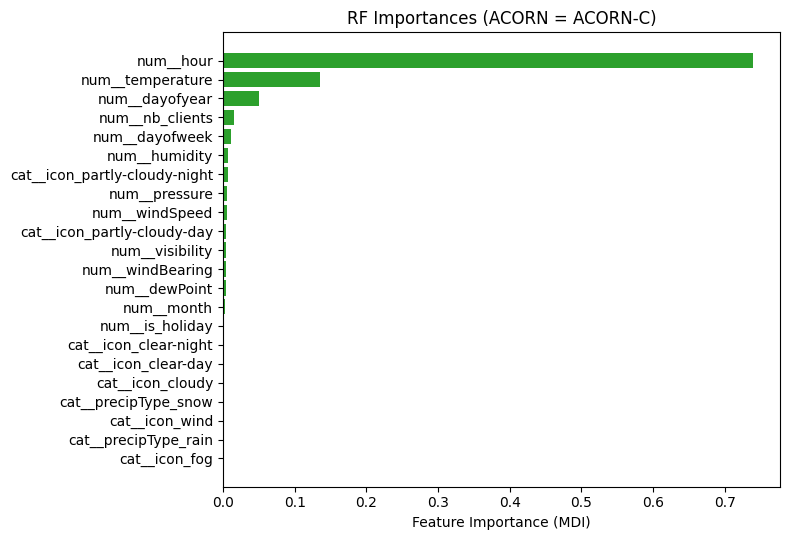

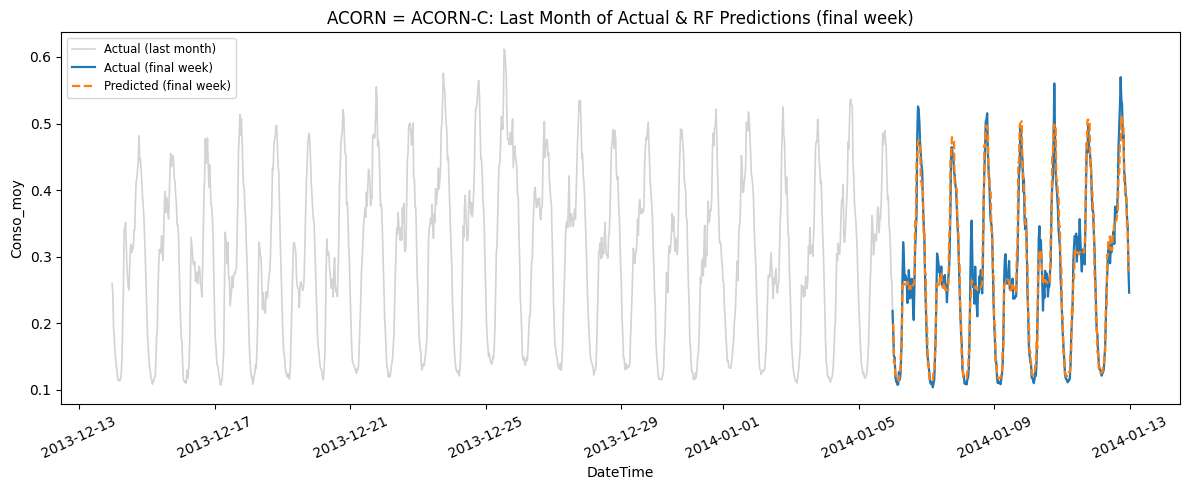


--- Best RF Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7030
    num__temperature                0.1889
    num__dayofyear                  0.0492
    num__dayofweek                  0.0192
    num__nb_clients                 0.0071
    num__windSpeed                  0.0046
    num__pressure                   0.0042
    num__dewPoint                   0.0041
    num__humidity                   0.0040
    num__visibility                 0.0038


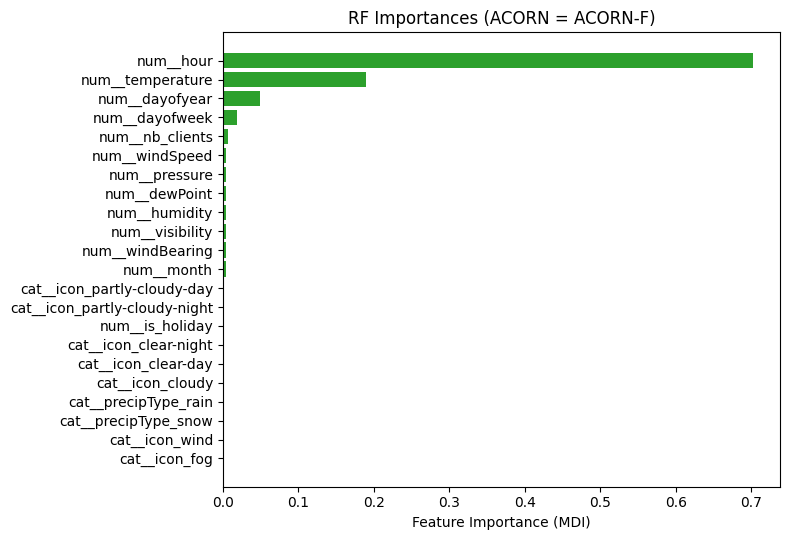

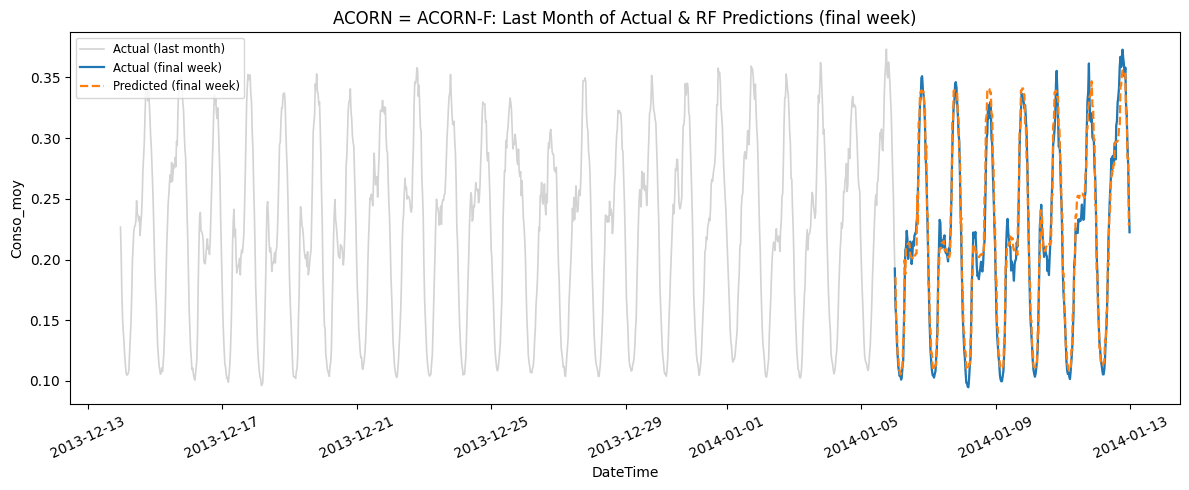


--- Best RF Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5882
    num__temperature                0.0688
    num__dayofyear                  0.0549
    num__dewPoint                   0.0426
    num__nb_clients                 0.0409
    num__month                      0.0380
    num__pressure                   0.0228
    num__visibility                 0.0223
    num__windSpeed                  0.0218
    num__windBearing                0.0210


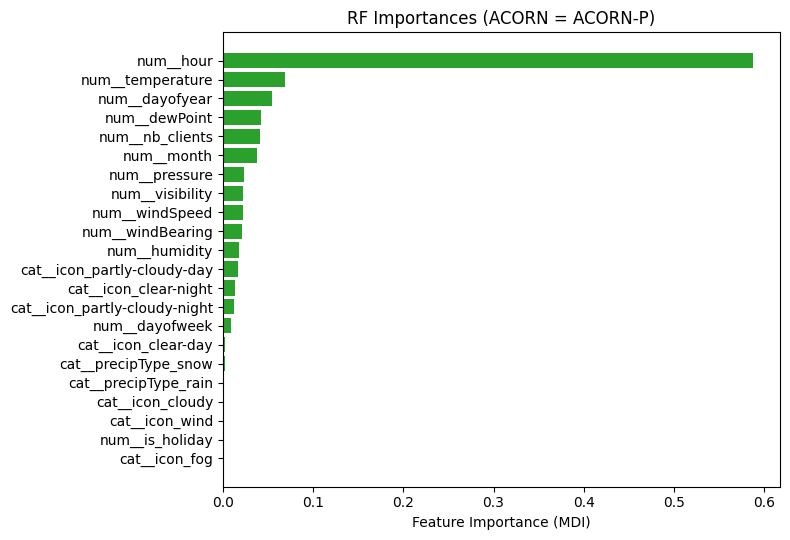

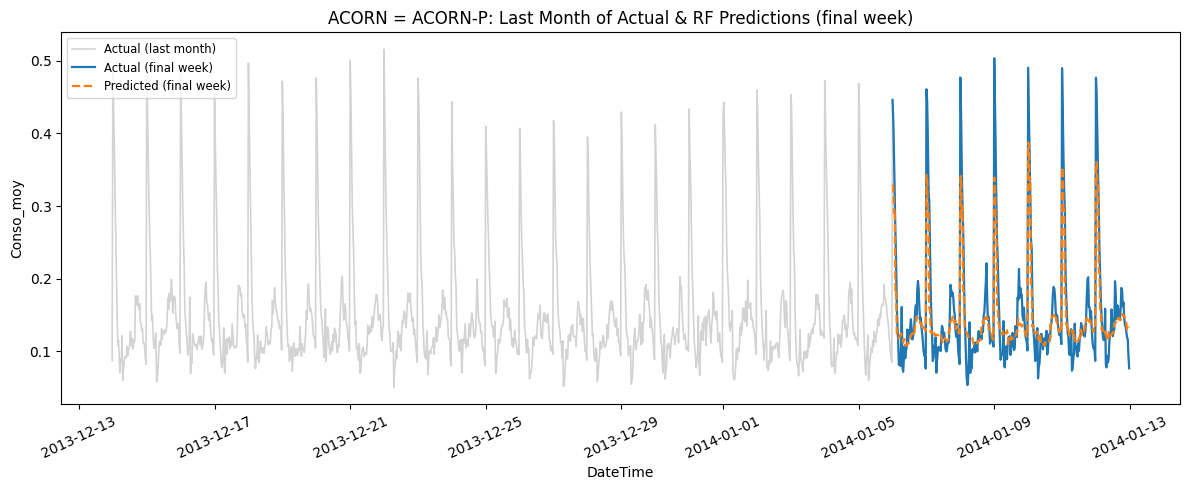

In [34]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) FEATURE IMPORTANCE AND PLOTTING LAST MONTH PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # 6.A) FEATURE IMPORTANCE
    print(f"\n--- Best RF Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # 6.A.1) Retrieve post‐transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # 6.A.2) Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # 6.B) PLOT LAST MONTH WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_month_ago  = last_timestamp - pd.Timedelta(days=30)
    last_month_df  = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last month (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last month)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Month of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

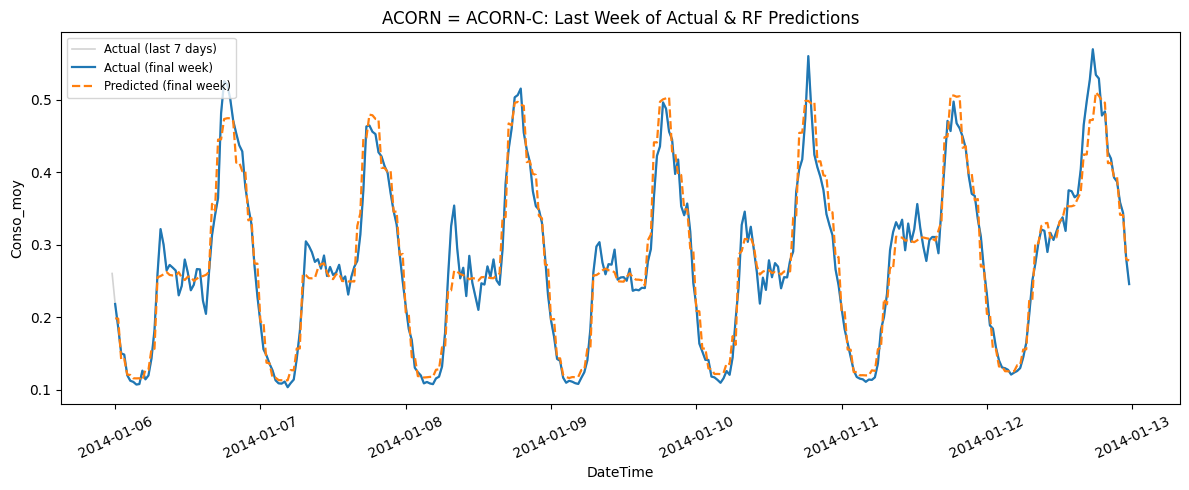

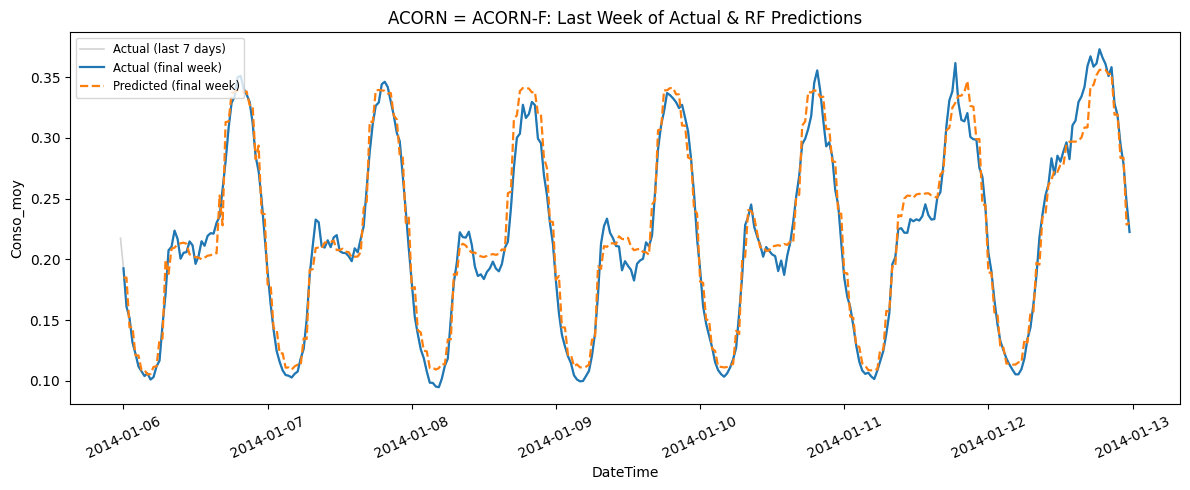

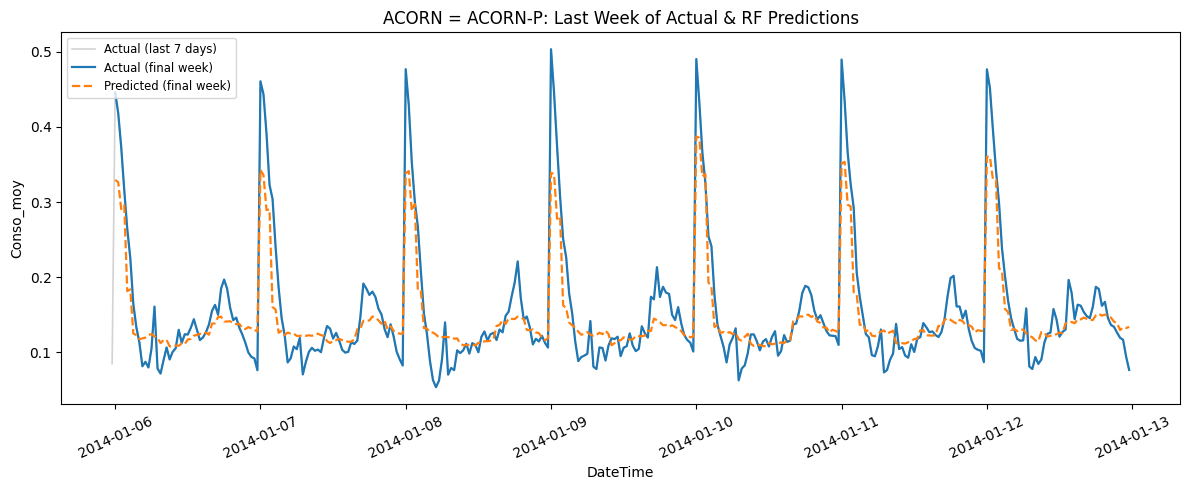

In [35]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot only the last week of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # 1) Full history for this ACORN, sorted by DateTime
    full_group     = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # 2) Compute one week ago
    one_week_ago = last_timestamp - pd.Timedelta(days=7)
    
    # 3) Filter to only the last 7 days of actual consumption
    last_week_df = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    # 4) Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # 5) Plot
    plt.figure(figsize=(12, 5))
    
    # 5A) Last 7 days actual (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # 5B) Actual final week (solid blue) – these 7 days include the last week
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()
